In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from itertools import product
import copy

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


 Epoch   1 | loss=0.9352 | val_f1=0.4465 | lr=0.001
 Epoch   2 | loss=0.7370 | val_f1=0.5579 | lr=0.001
 Epoch   3 | loss=0.6555 | val_f1=0.5776 | lr=0.001
 Epoch   4 | loss=0.6149 | val_f1=0.6216 | lr=0.001
 Epoch   5 | loss=0.5890 | val_f1=0.5832 | lr=0.001
 Epoch   6 | loss=0.5701 | val_f1=0.6601 | lr=0.001
 Epoch   7 | loss=0.5549 | val_f1=0.6265 | lr=0.001
 Epoch   8 | loss=0.5420 | val_f1=0.6362 | lr=0.001
 Epoch   9 | loss=0.5303 | val_f1=0.6490 | lr=0.001
 Epoch  10 | loss=0.5210 | val_f1=0.6620 | lr=0.001
 Epoch  11 | loss=0.5130 | val_f1=0.6635 | lr=0.001
 Epoch  12 | loss=0.5051 | val_f1=0.6569 | lr=0.001
 Epoch  13 | loss=0.4971 | val_f1=0.6177 | lr=0.001
 Epoch  14 | loss=0.4902 | val_f1=0.6539 | lr=0.001
 Epoch  15 | loss=0.4853 | val_f1=0.6606 | lr=0.0005
 Epoch  16 | loss=0.4506 | val_f1=0.6611 | lr=0.0005
 Epoch  17 | loss=0.4393 | val_f1=0.6562 | lr=0.0005
 Epoch  18 | loss=0.4324 | val_f1=0.6559 | lr=0.0005
 Epoch  19 | loss=0.4274 | val_f1=0.6245 | lr=0.00025
 Epoch

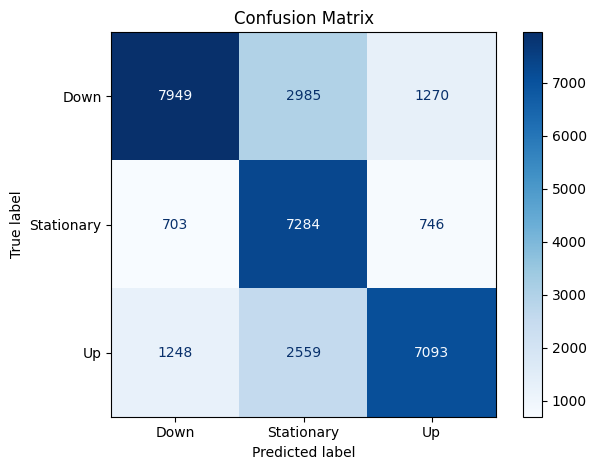

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

df = pd.read_csv("FI2010_train.csv")
split_idx = int((len(df)*4/5)//1)
train_df = df.iloc[ : split_idx]
val_df   = df.iloc[split_idx : ]
test_df = pd.read_csv("FI2010_test.csv")

x_train, y_train = train_df.iloc[:, :40], train_df["148"]
x_val, y_val = val_df.iloc[:, :40], val_df["148"]
x_test, y_test = test_df.iloc[:, :40], test_df["148"]

label_map = {1: 0, 2: 1, 3: 2}

y_train = np.vectorize(label_map.get)(y_train).astype(np.int64)
y_val = np.vectorize(label_map.get)(y_val).astype(np.int64)
y_test = np.vectorize(label_map.get)(y_test).astype(np.int64)

x_train = x_train.values
x_val = x_val.values
x_test = x_test.values

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

T = 100

class LOBSequenceDataset(Dataset):
    def __init__(self, X, y, T=100):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.T = T

    def __len__(self):
        return len(self.y) - self.T

    def __getitem__(self, idx):
        seq = self.X[idx : idx + self.T]
        return seq.T, self.y[idx + self.T]

batch_train = 64
batch_eval = 128

train_ds = LOBSequenceDataset(x_train, y_train, T=T)
val_ds   = LOBSequenceDataset(x_val, y_val, T=T)
test_ds  = LOBSequenceDataset(x_test, y_test, T=T)

train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_eval,  shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_eval,  shuffle=False)


counts = np.bincount(y_train[T:], minlength=3)
weights = 1.0 / counts
weights = weights / weights.sum() * 3
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

class InceptionBlock(nn.Module):
    def __init__(self, in_channels=40, out_channels=32, bottleneck_channels=32, kernels=(9, 19, 39)):
        super().__init__()

        self.use_bottleneck = in_channels > 1
        if self.use_bottleneck:
            self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
            conv_in = bottleneck_channels
        else:
            conv_in = in_channels

        self.branches = nn.ModuleList([
            nn.Conv1d(conv_in, out_channels, k, padding=k // 2, bias=False)
            for k in kernels
        ])

        self.pool = nn.AvgPool1d(kernel_size=3, stride=1, padding=1)
        self.pool_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        n_branches = len(kernels) + 1
        self.bn = nn.BatchNorm1d(out_channels * n_branches)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        if self.use_bottleneck:
            x_bn = self.bottleneck(x)
        else:
            x_bn = x

        outs = [branch(x_bn) for branch in self.branches]
        outs.append(self.pool_conv(self.pool(x)))
        out = torch.cat(outs, dim=1)
        return self.dropout(self.act(self.bn(out)))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels=40, out_channels=32, bottleneck_channels=32, kernels=(5, 11, 21)):
        super().__init__()
        n_filters = out_channels * (len(kernels) + 1)

        self.inception1 = InceptionBlock(in_channels, out_channels, bottleneck_channels, kernels)
        self.inception2 = InceptionBlock(n_filters, out_channels, bottleneck_channels, kernels)
        self.inception3 = InceptionBlock(n_filters, out_channels, bottleneck_channels, kernels)

        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels, n_filters, kernel_size=1, bias=False),
            nn.BatchNorm1d(n_filters),
        )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.inception1(x)
        out = self.inception2(out)
        out = self.inception3(out)
        return self.act(out + self.shortcut(x))


class InceptionTime(nn.Module):
    def __init__(self, in_channels=40, n_classes=3, n_blocks=2, out_channels=32,
                 bottleneck_channels=32, kernels=(9, 19, 39)):
        super().__init__()
        n_filters = out_channels * (len(kernels) + 1)

        blocks = []
        for i in range(n_blocks):
            block_in = in_channels if i == 0 else n_filters
            blocks.append(ResidualBlock(block_in, out_channels, bottleneck_channels, kernels))
        self.blocks = nn.Sequential(*blocks)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.head_dropout = nn.Dropout(0.35)
        self.head = nn.Linear(n_filters, n_classes)

    def forward(self, x):
        out = self.blocks(x)
        out = self.gap(out).squeeze(-1)
        out = self.head_dropout(out)
        return self.head(out)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y_batch.numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    return macro_f1, all_preds, all_labels

def train_model(model, train_loader, val_loader, criterion, lr=1e-3,
                max_epochs=100, patience=10, min_delta=1e-4):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3, min_lr=1e-6
    )
    best_state = None
    best_f1 = -1
    epochs_no_improve = 0
    history = {"train_loss":[], "val_f1":[]}

    for epoch in range(1, max_epochs+1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_f1, _, _ = evaluate(model, val_loader)
        history["train_loss"].append(train_loss)
        history["val_f1"].append(val_f1)
        scheduler.step(val_f1)
        current_lr = optimizer.param_groups[0]["lr"]
        print(f" Epoch {epoch:3d} | loss={train_loss:.4f} | val_f1={val_f1:.4f} | lr={current_lr}")

        if val_f1 > best_f1 + min_delta:
            best_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at {epoch}, best val_f1:{best_f1:.4f}")
            break

    model.load_state_dict(best_state)
    return model, history, best_f1

search_space = {
    "kernels": [
        [5, 11, 21, 41]
        [3, 7, 15, 21],
        [5, 11, 21],
        [3, 7, 15],
    ],
    "lr": [1e-3]
}

def run_hyperparameter_search(search_space, train_loader, val_loader, class_weights):
    keys = list(search_space.keys())
    combinations = list(product(*(search_space[k] for k in keys)))
    results = []

    for i, vals in enumerate(combinations):
        config = dict(zip(keys, vals))

        model = InceptionTime(kernels=config["kernels"]).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights)

        model, history, best_val_f1 = train_model(
            model, train_loader, val_loader, criterion,
            lr=config["lr"], max_epochs=100, patience=10
        )

        n_params = sum(p.numel() for p in model.parameters())
        config["val_f1"] = best_val_f1
        config["params"] = n_params
        config["model_state"] = copy.deepcopy(model.state_dict())
        results.append(config)

        print(f"val_f1={best_val_f1:.4f} | params={n_params:,}\n")

    results.sort(key=lambda x: x["val_f1"], reverse=True)

    return results

if __name__ == "__main__":
    results = run_hyperparameter_search(search_space, train_loader, val_loader, class_weights)
    best = results[0]
    print(f"Best config: kernels={best['kernels']} | lr={best['lr']}")

    best_model = InceptionTime(kernels=best["kernels"]).to(device)

    best_model.load_state_dict(best["model_state"])

    test_f1, test_preds, test_labels = evaluate(best_model, test_loader)

    print(f"\nTest macro-F1: {test_f1:.4f}")
    print(f"\nPer class report: \n{classification_report(test_labels, test_preds, target_names=['Down','Stationary','Up'])}")
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Stationary', 'Up'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=150)
    plt.show()